
Rodada 1 da Apuração STV:
     Candidato  Total
0  Candidato 1      6
1  Candidato 3      6
2  Candidato 2      3
3  Candidato 4      3
4  Candidato 5      3

O candidato Candidato 2 foi eliminado.

Rodada 2 da Apuração STV:
     Candidato  Total
0  Candidato 1      6
1  Candidato 3      6
2  Candidato 4      3
3  Candidato 5      3

O candidato Candidato 4 foi eliminado.

Rodada 3 da Apuração STV:
     Candidato  Total
0  Candidato 1      6
1  Candidato 3      6
2  Candidato 5      3

O candidato Candidato 5 foi eliminado.

Rodada 4 da Apuração STV:
     Candidato  Total
0  Candidato 1      6
1  Candidato 3      6

O candidato Candidato 1 foi eliminado.

Rodada 5 da Apuração STV:
     Candidato  Total
0  Candidato 3      6

O candidato Candidato 3 foi eliminado.

Os candidatos [] venceram por eliminação!
Vencedores: []


<ipython-input-1-c2762c1d7135>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votos.loc[index, colunas_candidatos[i]] = row[colunas_candidatos[i+1]]
<ipython-input-1-c2762c1d7135>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votos.loc[index, colunas_candidatos[i+1]] = '0000'  # Representa um voto nulo após a redistribuição


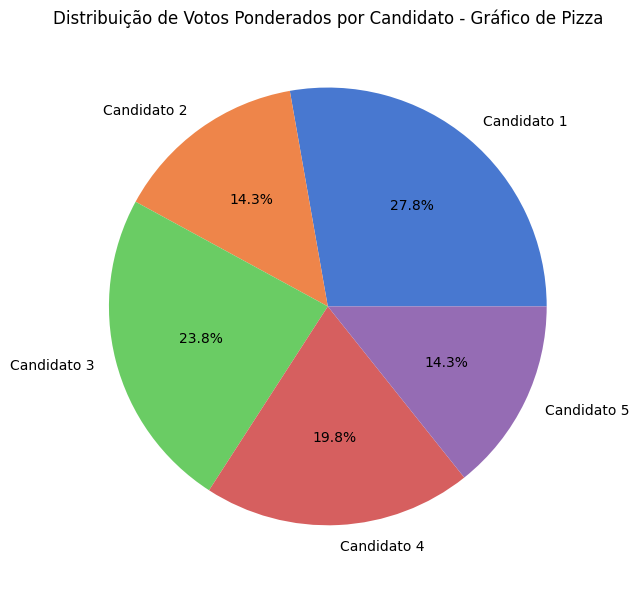

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gspread
from google.auth import default
from google.colab import auth

# Autenticação no Google Colab para acessar o Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Abrir a planilha pelo URL
planilha = gc.open_by_url('https://docs.google.com/spreadsheets/d/1q0-CREREQtkAUfGa6xh2V4Etb-ulcMdBaD-jfPakkKs/edit')

# Selecionar a aba da planilha (se necessário)
aba = planilha.sheet1

# Carregar os dados da aba em um DataFrame
df = pd.DataFrame(aba.get_all_records())

# Identificar as colunas de candidatos
colunas_candidatos = df.columns[1:]  # Exclui apenas a primeira coluna (timestamp)

# Preencher valores ausentes com '0000' (votos nulos) para as colunas de candidatos
df[colunas_candidatos] = df[colunas_candidatos].fillna('0000')

# Função para realizar a apuração STV
def apuracao_stv(df_votos, num_vencedores):
    candidatos = sorted(list(set(df_votos[colunas_candidatos[0]])))
    num_eleitores = len(df_votos)
    vencedores = []
    rodada = 1

    while len(vencedores) < num_vencedores and len(candidatos) > 0:
        print(f"\nRodada {rodada} da Apuração STV:")

        # Calcular os totais de votos da rodada
        totais = df_votos[colunas_candidatos[0]].value_counts().to_dict()

        # Criar um DataFrame para exibir os resultados da rodada
        resultados_rodada = pd.DataFrame(list(totais.items()), columns=['Candidato', 'Total'])
        print(resultados_rodada)

        # Verificar se algum candidato atingiu o quociente necessário para vencer
        quociente = num_eleitores / (num_vencedores + 1)
        vencedores_da_rodada = [c for c, v in totais.items() if v >= quociente]

        for vencedor in vencedores_da_rodada:
            print(f"\nO candidato {vencedor} atingiu o quociente e foi eleito!")
            vencedores.append(vencedor)
            candidatos.remove(vencedor)
            df_votos = df_votos[df_votos[colunas_candidatos[0]] != vencedor]

        if len(vencedores) >= num_vencedores:
            print("\nTodos os vencedores foram eleitos.")
            return vencedores

        # Encontrar o candidato com o menor número de votos e eliminar
        menor_votos = min(totais.values())
        candidatos_menor_voto = [c for c, v in totais.items() if v == menor_votos]
        candidato_eliminado = candidatos_menor_voto[0]

        print(f"\nO candidato {candidato_eliminado} foi eliminado.")
        candidatos.remove(candidato_eliminado)

        # Redistribuir os votos do candidato eliminado
        df_votos = df_votos[df_votos[colunas_candidatos[0]] != candidato_eliminado]

        # Ajustar as preferências dos eleitores que votaram no candidato eliminado
        for index, row in df_votos.iterrows():
            for i in range(len(colunas_candidatos) - 1):
                if row[colunas_candidatos[i]] == candidato_eliminado:
                    df_votos.loc[index, colunas_candidatos[i]] = row[colunas_candidatos[i+1]]
                    df_votos.loc[index, colunas_candidatos[i+1]] = '0000'  # Representa um voto nulo após a redistribuição

        rodada += 1

    # Se restar apenas um candidato ou candidatos suficientes, eles são os vencedores
    if len(candidatos) <= num_vencedores:
        vencedores.extend(candidatos)
        print(f"\nOs candidatos {vencedores} venceram por eliminação!")
        return vencedores

# Definir o número de vencedores e realizar a apuração
num_vencedores = 2
vencedores = apuracao_stv(df.copy(), num_vencedores)
print(f"Vencedores: {vencedores}")

# Função para calcular os totais de votos com base nas preferências dos eleitores
def calcular_totais(voting_df):
    """
    Calcula o total ponderado de votos para cada candidato com base nas preferências
    dos eleitores. A primeira escolha recebe o peso mais alto (número de candidatos),
    a segunda um peso menor, e assim por diante.
    """
    candidatos = sorted(list(set(voting_df[colunas_candidatos[0]])))
    resultados = {candidato: 0 for candidato in candidatos}
    pesos = list(range(len(colunas_candidatos), 0, -1))

    for _, row in voting_df.iterrows():
        for i, coluna in enumerate(colunas_candidatos):
            candidato = row[coluna]
            if candidato in resultados and candidato != '0000':
                resultados[candidato] += pesos[i]

    return pd.DataFrame(list(resultados.items()), columns=['Candidato', 'Total'])

# Calcular o total de votos para cada candidato
resultado = calcular_totais(df)

# Visualizar os resultados da votação com três gráficos

## Gráfico de pizza (remover candidatos com 0 votos)
resultado_pie = resultado[resultado['Total'] > 0]

plt.figure(figsize=(8, 6))
plt.pie(resultado_pie['Total'], labels=resultado_pie['Candidato'], autopct='%1.1f%%', colors=sns.color_palette('muted'))
plt.title('Distribuição de Votos Ponderados por Candidato - Gráfico de Pizza')
plt.tight_layout()
plt.show()